In [1]:
from food.tools import *
from food.paths import *
from food.psql import *
import requests
from food.qdrant import *
import torch
from torch.nn import CosineSimilarity
cos = CosineSimilarity(dim=1, eps=1e-08)
import numpy as np
import pandas as pd
from PIL import Image, ImageFont, ImageDraw, ImageEnhance

import shapely
import shapely.geometry
from PIL import ImageFont, ImageDraw, Image

dev


In [3]:
def read_image_from_url(url=None,path=None):
    if url: response = requests.get(url, stream=True)
    if path: pass
    return Image.open(response.raw)

In [4]:
def crop_image_to_square(img):
    height = img.size[1]//2*2
    left  = int((img.size[0]-height)/2)
    right =      img.size[0]-left
    return img.crop((left,0,right,height))

In [9]:
def box_area(box):
    return (box[2]-box[0])*(box[3]-box[1])

In [2]:
foods = read_sql('foods')
# foods = foods.drop(columns = ['clip'])
foods = foods.set_index('id')

In [14]:
series2tensor = lambda series:torch.tensor([np.array(c) for c in series.values])

In [16]:
food_clips = series2tensor(foods['clip'])

In [35]:
def search_clip(url,head = 1):
    image_clip = requests.post(f'https://guru.skynet.center/image2vector/?url={url}').json()
    image_clip = torch.tensor(image_clip)
    df = foods.copy()
    df['score'] = cos(food_clips,image_clip)
    df = df.sort_values('score',ascending=False)[:head]

    return image_clip,df.reset_index()

In [36]:
url = 'https://image.shutterstock.com/z/stock-photo-closeup-of-fresh-bruschetta-avocado-salmon-and-black-caviar-diet-morning-food-background-top-view-1721531143.jpg'
image = get_image_from_url(url)
image = crop_image_to_square(image)
total_size = image.size[0]*image.size[1]

In [37]:
thershold = 0.0003
params = {'url':url,'thershold':thershold}
boxes,mask = requests.post('http://127.0.0.1:8185/get_boxes/?',params = params).json()
mask = np.array(mask)

In [87]:
df = pd.DataFrame()
df['area'] = [box_area(box) for box in boxes]
df['boxes'] = boxes
df = df.reset_index()

In [88]:
photo_id = url.split('/')[-1]
urls = []
for d in df[['index','boxes']].to_dict('records'):
    id,box = d.values()
    urls.append(f'https://glovo.away.guru/fragment_reference_images/{photo_id}_{id}.jpg')
clip_df = pd.DataFrame()
for u in urls:
    clip_df = clip_df.append(search_clip(u,head = 1)[1])
clip_df = clip_df.reset_index(drop = True)[['description','category','energy','protein','carb','fat','score']]

In [89]:
df = clip_df.join(df)
df = df[df['score']>0.24]
df = df.sort_values('area',ascending = False)
df = df.reset_index(drop=True).reset_index()
df = df.rename(columns = {'level_0':'box_area_rank'})
# df = df.sort_values('box_area_rank',ascending = False)
df['boxes'] = df['boxes'].apply(lambda b:[int(bb) for bb in b])

In [90]:
arrays= []
for row in df[['box_area_rank','energy','boxes']].iterrows():
    
    row = row[1]
    b = row['boxes']
    rank   = np.zeros(image.size)
    rank  [b[1]:b[3],b[0]:b[2]] = row['box_area_rank']
    
    energy = np.zeros(image.size)
    energy  [b[1]:b[3],b[0]:b[2]]= row['energy']
    
    row_array = np.stack([rank,energy])
    arrays.append(row_array)
arrays = np.stack(arrays)
arrays = arrays*mask.T

In [91]:
classes =  arrays[:,0,:,:].max(0)

In [92]:
df_count_classes = df[['box_area_rank','description']].set_index('box_area_rank').reindex(classes.reshape(classes.shape[0]*classes.shape[0]))
df_count_classes = df_count_classes.dropna().reset_index().groupby('description').count().sort_values('box_area_rank',ascending = False).head(20)

In [93]:
colories_tensor = np.where((arrays[:,0,:,:] == arrays[:,0,:,:].max(0)),arrays[:,1,:,:],0).max(0)
colories_tensor[colories_tensor!=0].mean()

130.8866718236118

In [94]:
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = [15.00, 15.0]
plt.rcParams["figure.autolayout"] = True

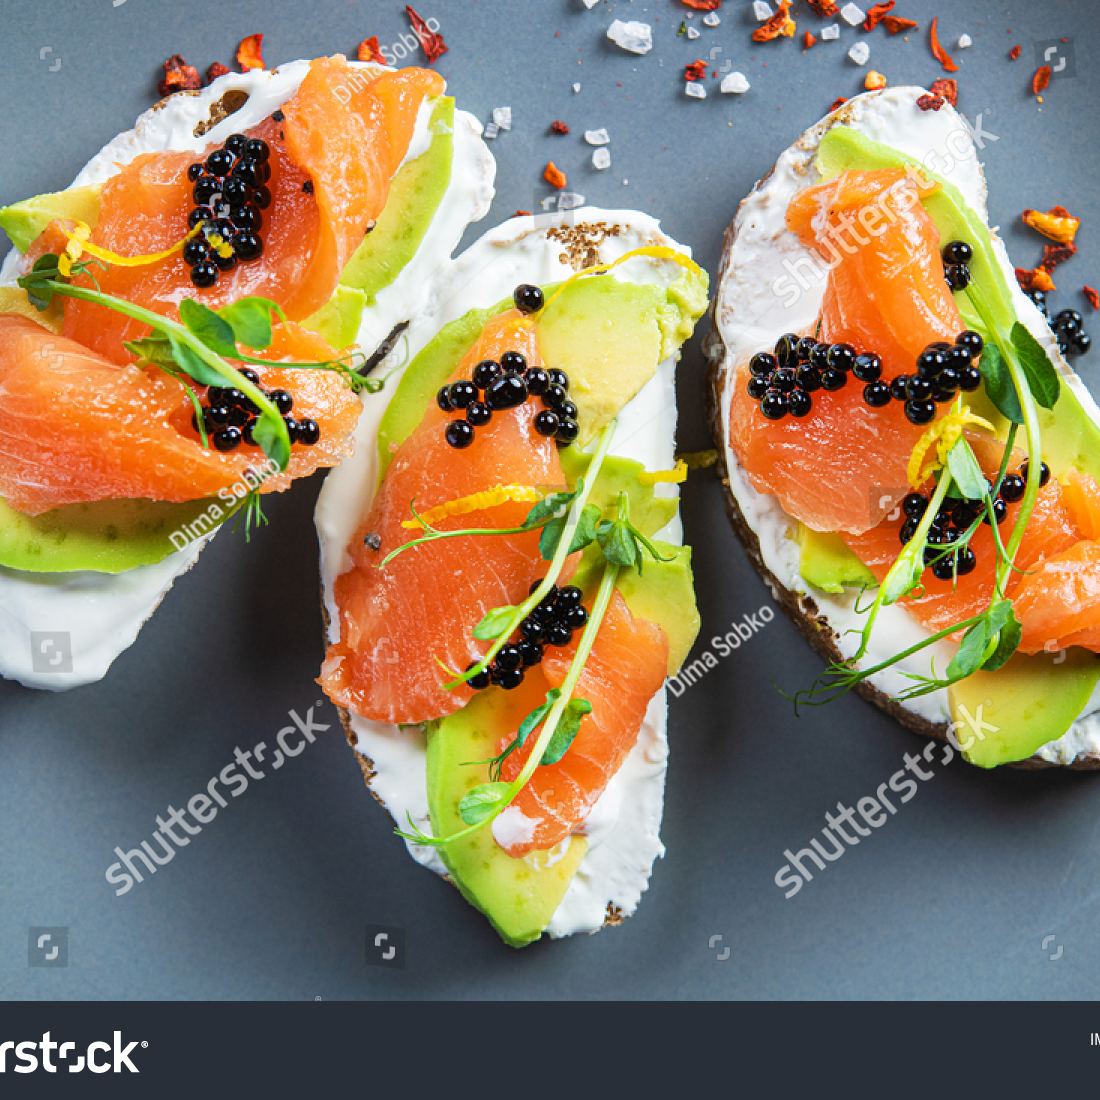

In [97]:
image

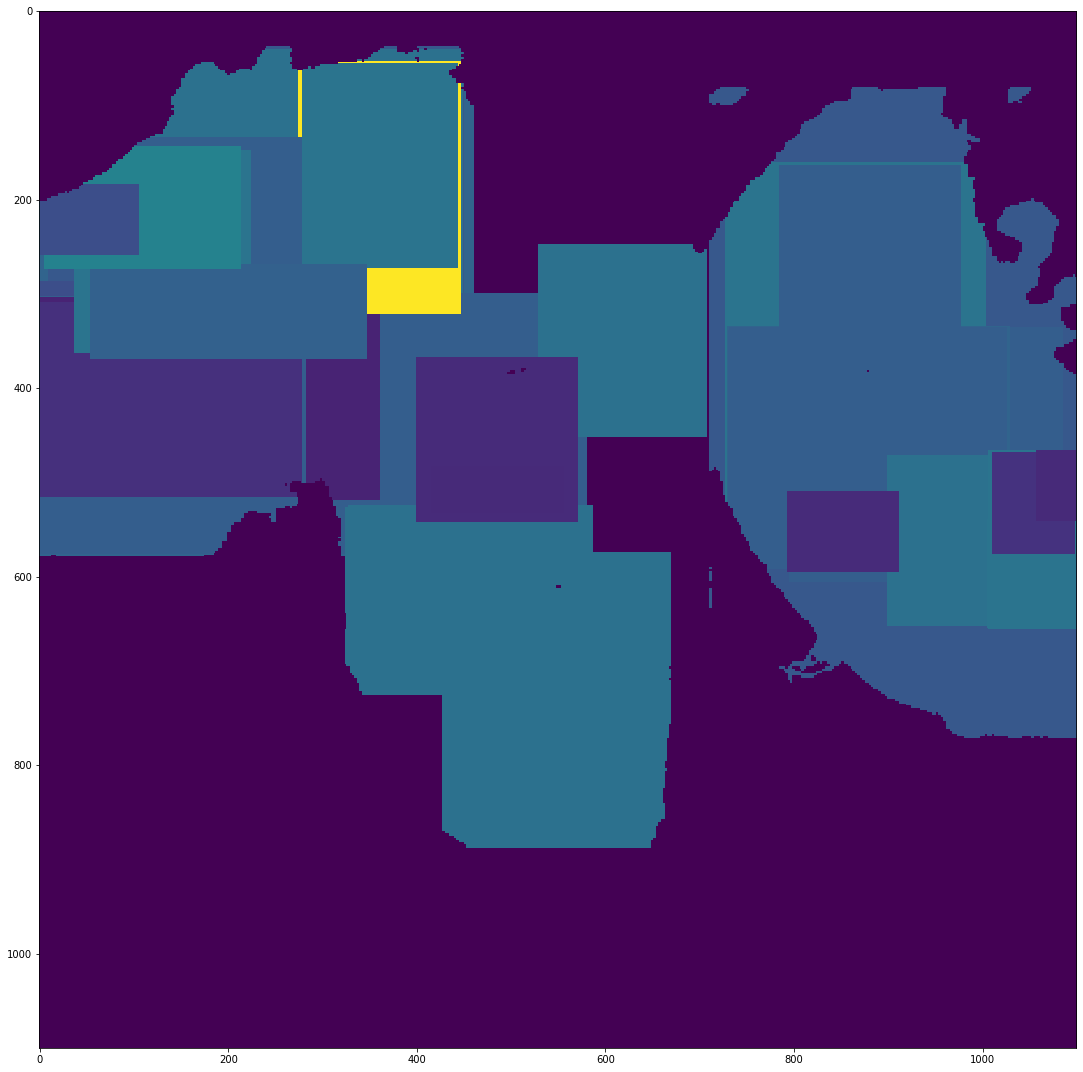

In [95]:
fig, ax = plt.subplots()
ax.imshow(image)
ax.imshow(colories_tensor, interpolation='none', alpha=1)

In [86]:
df_count_classes

,box_area_rank
description,
"Salmon, smoked",688479
"Salmon, raw",131155
"Salmon, steamed or poached",118641
"Salmon, baked or broiled, made with cooking spray",59560
Lomi salmon,42717
"Fruit salad, fresh or raw, including citrus fruits, no dressing",33148
"Avocado, raw",32873
"French or Catalina dressing, fat free",28734
"Salmon, cooked, NS as to cooking method",13218
